In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pandas as pd
import xarray as xr
import time

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable, vstack
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, Galactocentric, Galactic

import utils as ut
import plot_utils as pu
import data_retrieve_utils as dru

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
r = 11.4
d = 2
d_z = 0.6
r0 = 2
centers = dru.calculate_square_centers_excluding_inner_circle(r, d, r0)

Number of squares:  46


In [3]:
L = 49

ds_density = xr.open_dataset(f'../data/density_distro_galactic/MW_density_{L}.nc')

x_arr, y_arr, z_arr = ds_density.x.values, ds_density.y.values, ds_density.z.values
z = 0
density_disk = ds_density.sel(z=z, method='nearest').density
# mask eberything with positive x
density_disk = density_disk.where(density_disk.x <= 0, 0)

r=2
X, Y = np.meshgrid(x_arr, y_arr)  # Create a meshgrid for x and y coordinates
mask = np.sqrt(X**2 + Y**2) < r  # Calculate the mask based on the radius condition
density_disk = density_disk.where(~mask, 0)  # Apply the mask

R = 11.4
mask2 = np.sqrt(X**2 + Y**2) > R
density_disk = density_disk.where(~mask2, 0) 

density_disk /= density_disk.sum()

N = 1e5
N = int(N)
n_density = density_disk * N

print(n_density.sum())

# nn = 0
# for ctr in centers:
#     x, y = ctr
#     z = 0
#     dx, dy, dz = d, d, d_z
#     #print(f'x={x}, y={y}, z={z}')
#     x_max = x + dx/2
#     x_min = x - dx/2
#     y_max = y + dy/2
#     y_min = y - dy/2

#     selected_values = n_density.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#     n_val = int(selected_values.sum().values)
#     nn += int(n_val)
#     print(f'n_val={n_val}')

# print(nn)

<xarray.DataArray 'density' ()>
array(99999.99708671)
Coordinates:
    z        float64 0.0


In [4]:

for ctr in centers:
    x, y = ctr
    z = 0
    dx, dy, dz = d, d, d_z
    print(f'x={x}, y={y}, z={z}')

    x_max = x + dx/2
    x_min = x - dx/2
    y_max = y + dy/2
    y_min = y - dy/2

    selected_values = n_density.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    n_val = int(selected_values.sum().values)
    print(n_val)

    x_sun, y_sun, z_sun = -8.178, 0, 0
    flag = ''
    if (x_sun < x + dx/2) and (x_sun > x - dx/2):
        if (y_sun < y + dy/2) and (y_sun > y - dy/2):
            print('x_sun in range')
            p_max = 1/dx
            b = np.rad2deg(np.arctan2(dz, dx))
            adql_cond_gal = f"""
            (parallax > {p_max}) AND
            (b BETWEEN {-b} AND {b})"""
            flag = 'around_sun'

    else:
        l_lims, b_lims, d_lims = dru.galcen_dice_to_gal((x, y, z), (dx, dy, dz), fit_val=True)
        adql_cond_gal = dru.gal_cond_adql(l_lims, b_lims, d_lims)

    extra_cond = 'AND radial_velocity IS NOT null'
    adql_query = dru.dice_adql_query(adql_cond_gal, N=int(n_val), extra_cond=extra_cond)

    job = Gaia.launch_job_async(adql_query)
    data = job.get_results()

    print(f'N = {int(n_val)}, N_data={len(data)}')
    

    savefold = f'../data/stars_final2/disk/'
    if not os.path.exists(savefold):
        os.makedirs(savefold)

    # save data
    data.write(savefold + f'gaiadata_disk_{x:0.2f}_{y:0.2f}_{z:0.2f}_{dx}_{flag}.fits', overwrite=True)


x=-3.6690470119715, y=-10.4, z=0
355
Volume ratio: 0.6632892872436728
INFO: Query finished. [astroquery.utils.tap.core]
N = 355, N_data=355
x=-1.6690470119715002, y=-10.4, z=0
348
Volume ratio: 0.601099331003185


INFO: Query finished. [astroquery.utils.tap.core]
N = 348, N_data=348
x=-6.707139547199078, y=-8.4, z=0
482
Volume ratio: 0.877584178331048


INFO: Query finished. [astroquery.utils.tap.core]
N = 482, N_data=482
x=-4.707139547199078, y=-8.4, z=0
781
Volume ratio: 0.6989964883861344


INFO: Query finished. [astroquery.utils.tap.core]
N = 781, N_data=781
x=-2.707139547199078, y=-8.4, z=0
729
Volume ratio: 0.6181891650401314


INFO: Query finished. [astroquery.utils.tap.core]
N = 729, N_data=729
x=-0.7071395471990778, y=-8.4, z=0
1091
Volume ratio: 0.5831883889717684


INFO: Query finished. [astroquery.utils.tap.core]
N = 1091, N_data=1091
x=-8.433981132056603, y=-6.4, z=0
588


INFO: Query finished. [astroquery.utils.tap.core]
N = 588, N_data=588
x=-6.433981132056603, y=-6.4, z=0
974
Volume ratio: 0.8383229337911021


INFO: Query finished. [astroquery.utils.tap.core]
N = 974, N_data=974
x=-4.433981132056603, y=-6.4, z=0
1074
Volume ratio: 0.6784016210916489


INFO: Query finished. [astroquery.utils.tap.core]
N = 1074, N_data=1074
x=-2.433981132056603, y=-6.4, z=0
1969
Volume ratio: 0.6170430139124922


INFO: Query finished. [astroquery.utils.tap.core]
N = 1969, N_data=1969
x=-0.43398113205660316, y=-6.4, z=0
1750
Volume ratio: 0.598221621593706


INFO: Query finished. [astroquery.utils.tap.core]
N = 1750, N_data=1750
x=-9.516653460107927, y=-4.4, z=0
436
Volume ratio: 0.9154351135041038


INFO: Query finished. [astroquery.utils.tap.core]
N = 436, N_data=436
x=-7.516653460107927, y=-4.4, z=0
802


INFO: Query finished. [astroquery.utils.tap.core]
N = 802, N_data=802
x=-5.516653460107927, y=-4.4, z=0
1002
Volume ratio: 0.7767051322666504


INFO: Query finished. [astroquery.utils.tap.core]
N = 1002, N_data=1002
x=-3.5166534601079267, y=-4.4, z=0
2257
Volume ratio: 0.6750644872878653


INFO: Query finished. [astroquery.utils.tap.core]
N = 2257, N_data=2257
x=-1.5166534601079267, y=-4.4, z=0
3515
Volume ratio: 0.6486164932358638


INFO: Query finished. [astroquery.utils.tap.core]
N = 3515, N_data=3515
x=-10.144505372604026, y=-2.4000000000000004, z=0
640
Volume ratio: 1.1041345353420515


INFO: Query finished. [astroquery.utils.tap.core]
N = 640, N_data=640
x=-8.144505372604026, y=-2.4000000000000004, z=0
799


INFO: Query finished. [astroquery.utils.tap.core]
N = 799, N_data=799
x=-6.144505372604026, y=-2.4000000000000004, z=0
1969
Volume ratio: 1.1164182458502607


INFO: Query finished. [astroquery.utils.tap.core]
N = 1969, N_data=1969
x=-4.144505372604026, y=-2.4000000000000004, z=0
4369
Volume ratio: 0.8152966688674229


INFO: Query finished. [astroquery.utils.tap.core]
N = 4369, N_data=4369
x=-2.1445053726040264, y=-2.4000000000000004, z=0
6538
Volume ratio: 0.7648477458913826


INFO: Query finished. [astroquery.utils.tap.core]
N = 6538, N_data=6538
x=-10.392980294900891, y=-0.40000000000000036, z=0
479
Volume ratio: 1.398904920904784


INFO: Query finished. [astroquery.utils.tap.core]
N = 479, N_data=479
x=-8.392980294900891, y=-0.40000000000000036, z=0
1103
x_sun in range


INFO: Query finished. [astroquery.utils.tap.core]
N = 1103, N_data=1103
x=-6.392980294900891, y=-0.40000000000000036, z=0
2337
Volume ratio: 3.045996654175453


INFO: Query finished. [astroquery.utils.tap.core]
N = 2337, N_data=2337
x=-4.392980294900891, y=-0.40000000000000036, z=0
3836
Volume ratio: 1.6399172768384542


INFO: Query finished. [astroquery.utils.tap.core]
N = 3836, N_data=3836
x=-10.28716084761797, y=1.5999999999999996, z=0
348
Volume ratio: 1.3526577305630456


INFO: Query finished. [astroquery.utils.tap.core]
N = 348, N_data=348
x=-8.28716084761797, y=1.5999999999999996, z=0
791


INFO: Query finished. [astroquery.utils.tap.core]
N = 791, N_data=791
x=-6.287160847617971, y=1.5999999999999996, z=0
1628
Volume ratio: 1.6208803226276902


INFO: Query finished. [astroquery.utils.tap.core]
N = 1628, N_data=1628
x=-4.287160847617971, y=1.5999999999999996, z=0
2548
Volume ratio: 0.920827308978174


INFO: Query finished. [astroquery.utils.tap.core]
N = 2548, N_data=2548
x=-9.816653826391969, y=3.5999999999999996, z=0
470
Volume ratio: 0.9290789351693576


INFO: Query finished. [astroquery.utils.tap.core]
N = 470, N_data=470
x=-7.816653826391969, y=3.5999999999999996, z=0
1035


INFO: Query finished. [astroquery.utils.tap.core]
N = 1035, N_data=1035
x=-5.816653826391969, y=3.5999999999999996, z=0
1970
Volume ratio: 0.8519166076318413


INFO: Query finished. [astroquery.utils.tap.core]
N = 1970, N_data=1970
x=-3.8166538263919687, y=3.5999999999999996, z=0
2686
Volume ratio: 0.7156072964538767


INFO: Query finished. [astroquery.utils.tap.core]
N = 2686, N_data=2686
x=-1.8166538263919687, y=3.5999999999999996, z=0
6137
Volume ratio: 0.6831386866811611


INFO: Query finished. [astroquery.utils.tap.core]
N = 6137, N_data=6137
x=-8.929753269845127, y=5.6, z=0
537


INFO: Query finished. [astroquery.utils.tap.core]
N = 537, N_data=537
x=-6.929753269845127, y=5.6, z=0
964
Volume ratio: 0.9158979981079154


INFO: Query finished. [astroquery.utils.tap.core]
N = 964, N_data=964
x=-4.929753269845127, y=5.6, z=0
1108
Volume ratio: 0.7098380083957292


INFO: Query finished. [astroquery.utils.tap.core]
N = 1108, N_data=1108
x=-2.9297532698451274, y=5.6, z=0
2178
Volume ratio: 0.6355209245747554


INFO: Query finished. [astroquery.utils.tap.core]
N = 2178, N_data=2178
x=-0.9297532698451274, y=5.6, z=0
2838
Volume ratio: 0.6140862604535672


INFO: Query finished. [astroquery.utils.tap.core]
N = 2838, N_data=2838
x=-7.497058314499203, y=7.6, z=0
422


INFO: Query finished. [astroquery.utils.tap.core]
N = 422, N_data=422
x=-5.497058314499203, y=7.6, z=0
469
Volume ratio: 0.7478039191611034


INFO: Query finished. [astroquery.utils.tap.core]
N = 469, N_data=469
x=-3.4970583144992027, y=7.6, z=0
830
Volume ratio: 0.6401786127995771


INFO: Query finished. [astroquery.utils.tap.core]
N = 830, N_data=830
x=-1.4970583144992027, y=7.6, z=0
1023
Volume ratio: 0.5953358293008735


INFO: Query finished. [astroquery.utils.tap.core]
N = 1023, N_data=1023
x=-5.14817045957576, y=9.6, z=0
451
Volume ratio: 0.7371697496303169


INFO: Query finished. [astroquery.utils.tap.core]
N = 451, N_data=451
x=-3.14817045957576, y=9.6, z=0
707
Volume ratio: 0.6371986444792641


INFO: Query finished. [astroquery.utils.tap.core]
N = 707, N_data=707
x=-1.14817045957576, y=9.6, z=0
593
Volume ratio: 0.5885492696667408


INFO: Query finished. [astroquery.utils.tap.core]
N = 593, N_data=593


In [428]:
data = dru.preprocess_data(data)
data = dru.get_galcen_table(data)

# savefold = f'../data/stars/halo/'
# if not os.path.exists(savefold):
#     os.makedirs(savefold)

# # save data
# data.write(savefold + f'gaiadata_halo_{x}_{y}_{z}_{dx}.fits', overwrite=True)

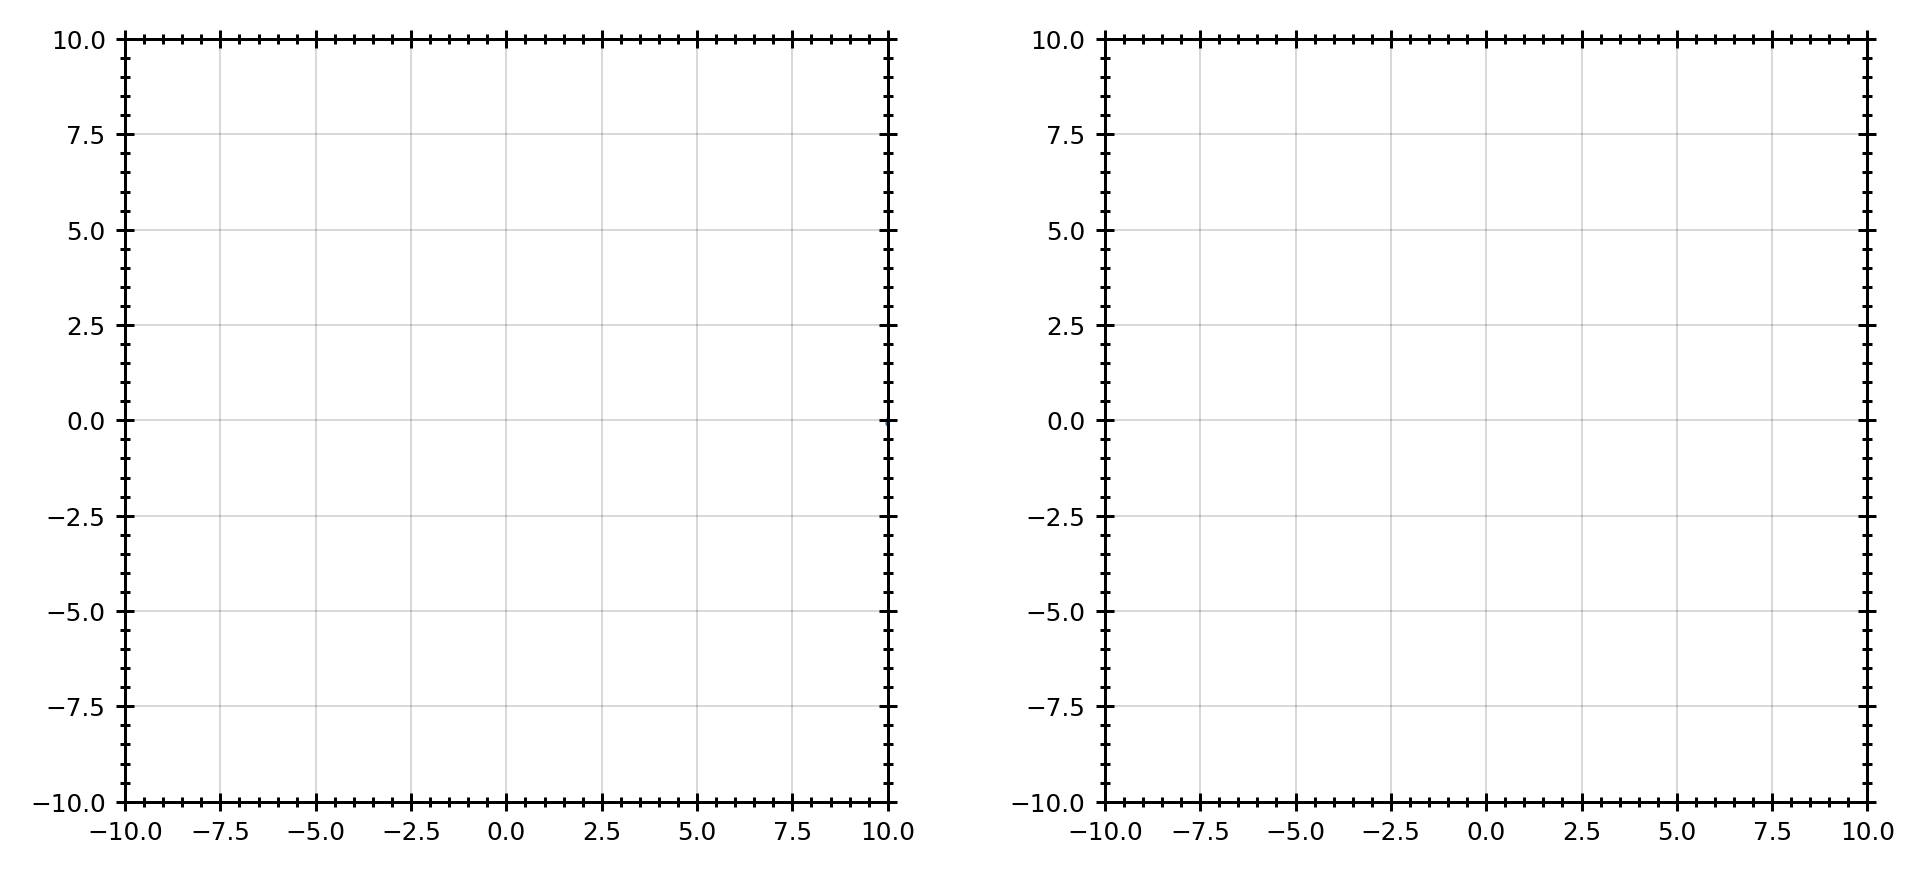

In [429]:
size, rat = 1080, 1.75
fig_w, fig_h = size*rat, size
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, ts=1.25, minor=True, top_bool=True, tick_direction='inout',
                                   wspace=0.1)
lim = 10
ss = 0.5
axs[0][0].scatter(data['x'], data['y'], 
           #c=colors_xy, cmap='gnuplot', 
           s=ss*fs, linewidths=0)


axs[0][1].scatter(data['x'], data['z'], 
            #c=colors_xz, cmap='gnuplot', 
            s=ss*fs, linewidths=0)

axs = [axs[0][0], axs[0][1]]
for ax in axs:
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')

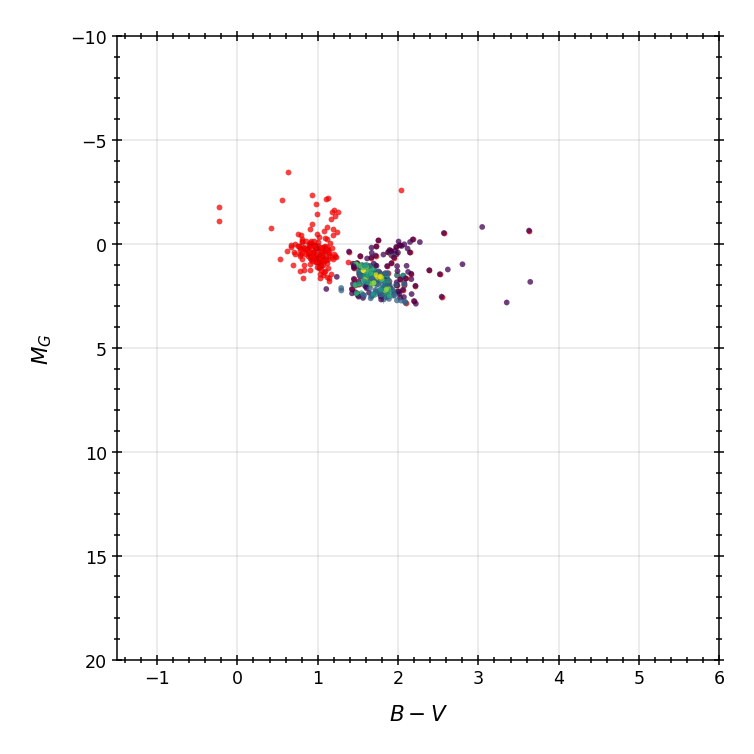

In [364]:
size, rat = 720, 1
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, ts=1.75, minor=True, top_bool=True, tick_direction='inout',
                                   wspace=0.1)

ax = axs[0][0]
bp_rp_mag, g_abs = data['bp_rp_mag'], data['g_abs']
colors = np.log10(pu.get_hist_scatter_colors(bp_rp_mag, g_abs,
                x_lims=[np.min(bp_rp_mag), np.max(bp_rp_mag)],
                y_lims=[np.min(g_abs), np.max(g_abs)],
                bins=[10, 10], spherical=False))

ax.scatter(bp_rp_mag, g_abs, 
            s=0.75*fs, 
            c=colors, 
            alpha=0.75, zorder=2,
            linewidths=0.01*fs, edgecolor='k')

ax.set_xlabel(r'$B-V$', fontsize=2.15*fs)
ax.set_ylabel(r'$M_G$', fontsize=2.15*fs)


for xi, yi, x_err_i, y_err_i in zip(data['bp_rp_mag'], data['g_abs'], 
                                    data['bp_rp_mag_error'], data['g_abs_error']):
    
    #if (x_err_i > color_max_err) or (y_err_i > lum_max_err):

    rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
    ax.add_patch(rect)

ax.set_xlim(-1.5,6)
ax.set_ylim(-10, 20)

bp_rp_mag_corr = bp_rp_mag  - data['ebpminrp_gspphot'].filled(0)
g_abs_corr = g_abs - data['ag_gspphot'].filled(0)

ax.scatter(bp_rp_mag_corr, g_abs_corr, 
            s=0.75*fs, 
            #c=colors, 
            color='r',
            alpha=0.75, zorder=1,
            linewidths=0.01*fs, edgecolor='k')

ax.invert_yaxis()

Text(0, 0.5, '$V_r$ (mas/yr)')

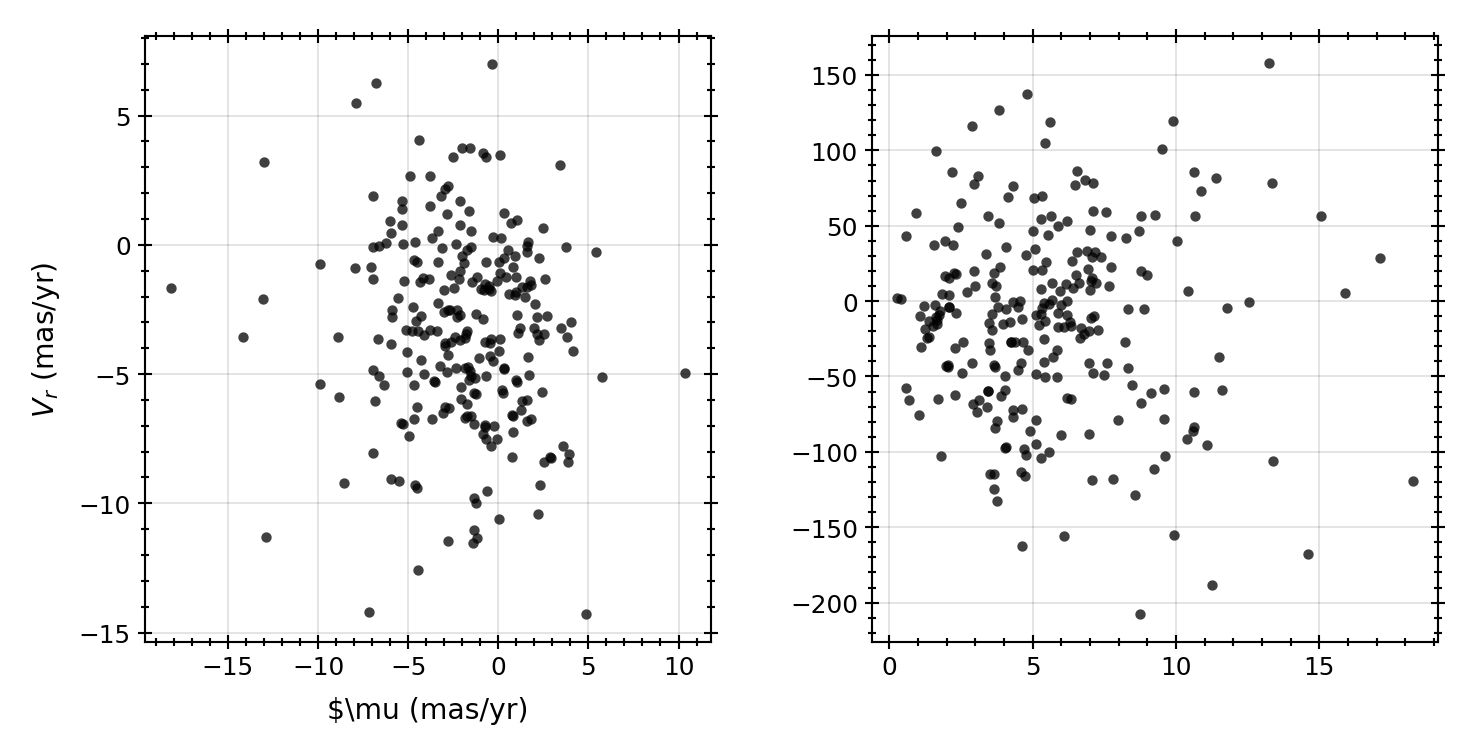

In [365]:
size, rat = 720, 2
fig_w, fig_h = size*rat, size
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, ts=1.75, minor=True, top_bool=True, tick_direction='inout',
                                   wspace=0.1)

ax = axs[0][0]
x, y = data['pmra'], data['pmdec']
x_err, y_err = data['pmra_error'], data['pmdec_error']
pmot_arr = np.array([x, y]).T


c = 'k'

ax.scatter(pmot_arr[:, 0], pmot_arr[:, 1], c=c, s=1.75*fs, zorder=4, 
linewidths=0.01*fs, edgecolor='k', alpha=0.75)

for xi, yi, x_err_i, y_err_i in zip(x, y, x_err, y_err):
    rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.25)
    ax.add_patch(rect)

ax.set_xlabel(r'$\mu_{\alpha^*}$ (mas/yr)', fontsize=2*fs)
ax.set_ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=2*fs)

ax2 = axs[0][1]

v = np.sqrt(x**2 + y**2)
v_err = np.sqrt((x_err * x/v)**2 + (y_err * x/v)**2)
rv = data['radial_velocity']
rv_err = data['radial_velocity_error']
v_arr = np.array([v, rv]).T

x_err, y_err = data['pmra_error'], data['pmdec_error']

ax2.scatter(v_arr[:, 0], v_arr[:, 1], c=c, s=1.75*fs, zorder=4, 
linewidths=0.01*fs, edgecolor='k', alpha=0.75)

ax.set_xlabel(r'$\mu (mas/yr)', fontsize=2*fs)
ax.set_ylabel(r'$V_r$ (mas/yr)', fontsize=2*fs)

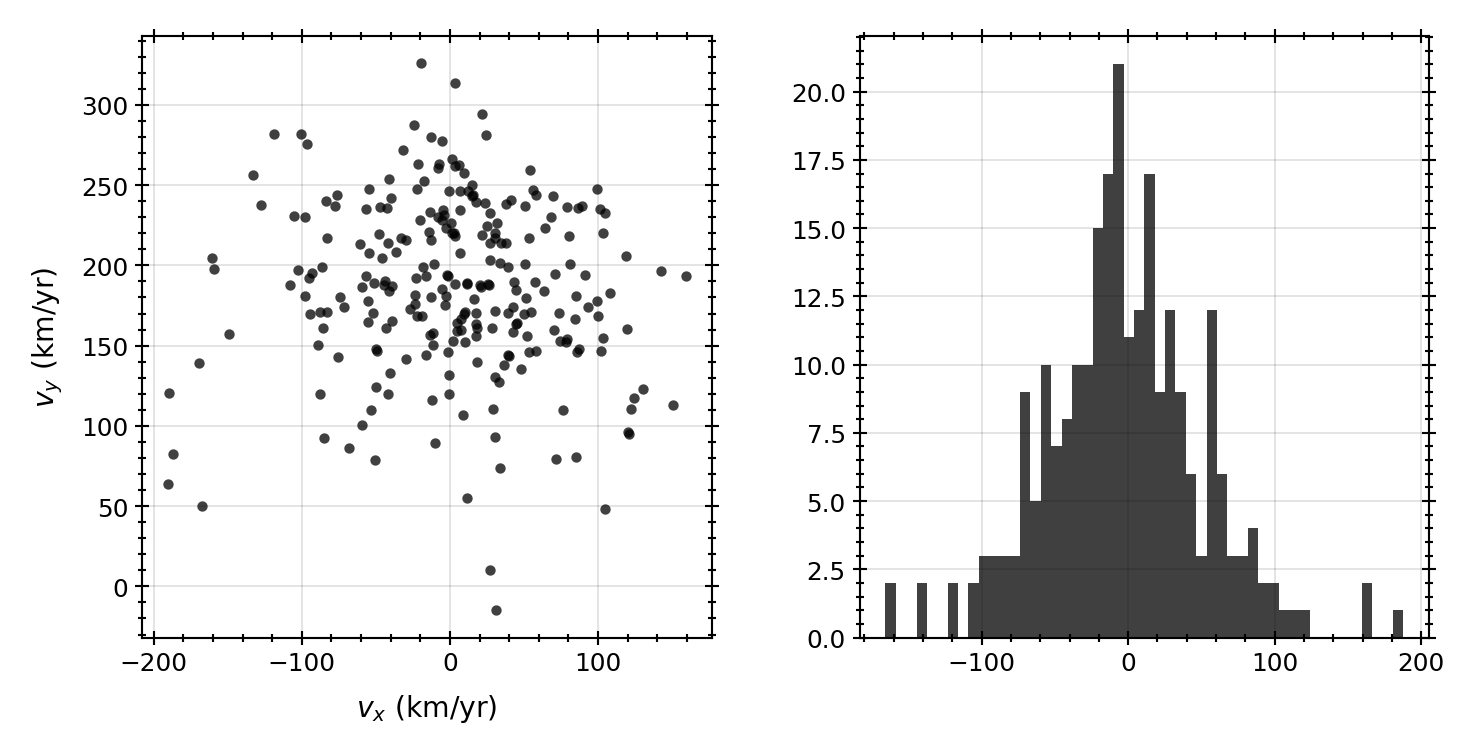

In [366]:
size, rat = 720, 2
fig_w, fig_h = size*rat, size
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, ts=1.75, minor=True, top_bool=True, tick_direction='inout',
                                   wspace=0.1)

ax = axs[0][0]
x, y = data['v_x'], data['v_y']
pmot_arr = np.array([x, y]).T

c = 'k'

ax.scatter(pmot_arr[:, 0], pmot_arr[:, 1], c=c, s=1.75*fs, zorder=4, 
linewidths=0.01*fs, edgecolor='k', alpha=0.75)


ax.set_xlabel(r'$v_x$ (km/yr)', fontsize=2*fs)
ax.set_ylabel(r'$v_y$ (km/yr)', fontsize=2*fs)

ax2 = axs[0][1]

z = data['v_z']

# histogram of vz
ax2.hist(z, bins=50, color='k', alpha=0.75, linewidth=1.5*fs)

a=1